In [104]:
import numpy as np
import h5py
import sys


sys.path.append(".")
dirname = "./bgw_files/k-2x2x2/"

In [105]:
# epsinp and sigmain data.
from qtm.interfaces.bgw.epsinp import Epsinp
epsinp = Epsinp.from_epsilon_inp(filename=dirname+'epsilon.inp')

from qtm.interfaces.bgw.sigmainp import Sigmainp
sigmainp = Sigmainp.from_sigma_inp(filename=dirname+'sigma.inp')

In [106]:
from qtm.interfaces.bgw import inp
from qtm.interfaces.bgw.wfn2py import wfn2py

# Read wfndata
wfndata = wfn2py(dirname + "WFN.h5")
wfnqdata = wfn2py(dirname + "WFNq.h5")

# Read rho
rho = inp.read_rho(dirname + "RHO")

# Read vxc 
vxc = inp.read_vxc(dirname + "vxc.dat") 

In [107]:
from qtm.gw.core import QPoints
from qtm.gw.epsilon import Epsilon

epsilon = Epsilon.from_data(wfndata=wfndata, wfnqdata=wfnqdata, epsinp=epsinp)

Vcoul calculation for qpts: 100%|██████████| 8/8 [00:00<00:00, 19239.93it/s]


In [108]:
from tqdm import trange
from qtm.gw.core import reorder_2d_matrix_sorted_gvecs, sort_cryst_like_BGW


def calculate_epsilon(numq=None, writing=False):
    epsmats = []
    if numq is None:
        numq = epsilon.qpts.numq

    for i_q in trange(0, numq, desc="Epsilon> q-pt index"):
        # Create map between BGW's sorting order and QTm's sorting order
        gkspc = epsilon.l_gq[i_q]
        
        if i_q == epsilon.qpts.index_q0:
            key = gkspc.g_norm2
        else:
            key = gkspc.gk_norm2

        indices_gspace_sorted = sort_cryst_like_BGW(
            cryst=gkspc.g_cryst, key_array=key
        )
       

        # Calculate matrix elements
        M = next(epsilon.matrix_elements(i_q=i_q))

        # Calculate polarizability matrix (faster, but not memory-efficient)
        chimat = epsilon.polarizability(M)

        # Calculate polarizability matrix (memory-efficient)
        # chimat = epsilon.polarizability_active(i_q)

        # Calculate epsilon inverse matrix
        epsinv0 = epsilon.epsilon_inverse(i_q=i_q, polarizability_matrix=chimat, store=True)
        epsinv = reorder_2d_matrix_sorted_gvecs(epsinv0, indices_gspace_sorted)

        epsilon.l_epsinv[i_q] = epsinv

        
        # Compare the results with BGW's results
        if i_q == epsilon.qpts.index_q0:
            epsref = epsilon.read_epsmat(dirname + "eps0mat.h5")[0][0, 0]
            if writing:
                epsilon.write_epsmat(
                    filename="test/epsilon/eps0mat_qtm.h5", epsinvmats=[epsinv]
                )
        else:
            epsref = np.array(epsilon.read_epsmat(dirname + "epsmat.h5")[i_q - 1][0, 0])
            epsmats.append(epsinv)

        # Calculate stddev between reference and calculated epsinv matrices
        std_eps = np.std(epsref - epsinv) / np.sqrt(np.prod(list(epsinv.shape)))


        epstol = 1e-16
        if np.abs(std_eps) > epstol:
            print(f"Standard deviation exceeded {epstol} tolerance: {std_eps}, for i_q:{i_q}")


    if writing:
        epsilon.write_epsmat(filename="test/epsilon/epsmat_qtm.h5", epsinvmats=epsmats)


epsinp.no_min_fftgrid = True
epsilon = Epsilon.from_data(wfndata=wfndata, wfnqdata=wfnqdata, epsinp=epsinp)

calculate_epsilon()

Epsilon> q-pt index: 100%|██████████| 8/8 [00:00<00:00, 135.15it/s]

Standard deviation exceeded 1e-16 tolerance: 2.5494915419483335e-15, for i_q:0


In [109]:
from kernel import KernelMtxEl

q0val = [0.001, 0.001, 0.001]


In [110]:
kernelclass = KernelMtxEl.from_BGW(
    wfndata=wfndata,
    epsinp=epsinp,
    sigmainp=sigmainp,
    l_epsmats=epsilon.l_epsinv,
    q0=q0val,
    parallel=False,
    num_bands_val=2,
    num_bands_con=1,
)

In [111]:
data = kernelclass.kernel_mtxel()

In [112]:
exc = data["exc"]
print(exc.shape)
exc = exc[:, 0, 0, 0, :, 0]

for row in range(exc.shape[0]):
    row_data = []
    for col in range(exc.shape[1]):
        row_data.append(f"{exc[row, col]:.5f}")
    print(" | ".join(row_data))

(8, 8, 1, 1, 2, 2)
0.47881-0.00000j | -0.04249-0.11703j
-0.02994-0.11418j | -0.09566-0.02049j
-0.07084-0.02386j | -0.07431-0.08646j
-0.06933+0.12470j | 0.00074+0.00153j
-0.10282+0.15727j | -0.01911+0.00103j
0.01616-0.05548j | 0.00116-0.00065j
0.02306+0.09088j | -0.00104+0.00002j
0.00050-0.00007j | -0.00079+0.00097j


In [113]:
head = data["head"]
head = head[:, 0, 0, 0, :, 0]

for row in range(head.shape[0]):
    row_data = []
    for col in range(head.shape[1]):
        row_data.append(f"{head[row, col]:.5f}")
    print(" | ".join(row_data))

1.00000-0.00000j | -0.00000+0.00000j
-0.05016-0.19131j | -0.00125-0.00027j
-0.11326-0.03814j | 0.00013+0.00015j
-0.12329+0.21733j | -0.00113+0.00381j
-0.17991+0.27518j | -0.00256+0.00014j
0.02843-0.09821j | 0.00201-0.00116j
0.04308+0.15990j | -0.00157+0.00185j
-0.00000+0.00000j | -0.00008+0.00010j


In [114]:
wings = data["wings"]
wings = wings[:, 0, 0, 0, :, 0]

for row in range(wings.shape[0]):
    row_data = []
    for col in range(wings.shape[1]):
        row_data.append(f"{wings[row, col]:.5f}")
    print(" | ".join(row_data))

0.00000+0.00000j | 0.00000+0.00000j
-0.02333-0.08898j | -0.00058-0.00013j
-0.05267-0.01774j | 0.00006+0.00007j
0.00336-0.00592j | 0.00003-0.00010j
-0.08366+0.12798j | -0.00119+0.00007j
-0.00077+0.00268j | -0.00005+0.00003j
-0.00117-0.00436j | 0.00004-0.00005j
-0.00000+0.00000j | -0.00007+0.00008j


In [115]:
body = data["body"]
body = body[:, 0, 0, 0, :, 0]

for row in range(body.shape[0]):
    row_data = []
    for col in range(body.shape[1]):
        row_data.append(f"{body[row, col]:.5f}")
    print(" | ".join(row_data))

0.26817-0.00000j | -0.02549-0.07022j
-0.08153-0.31100j | 0.05704+0.01221j
-0.18194-0.06128j | 0.04663+0.05426j
-0.20591+0.37437j | 0.00442+0.00351j
-0.29583+0.45252j | 0.00681-0.00036j
0.04851-0.16597j | 0.00348-0.00192j
0.06688+0.27254j | -0.00317-0.00162j
0.01449-0.00175j | -0.00377+0.00461j


In [116]:
with h5py.File(dirname + 'bsemat.h5', 'r') as f:
    body_BGW = f['mats/body']
    head_BGW = f['mats/head']
    wings_BGW = f['mats/wing']
    exc_BGW = f['mats/exchange']

    body_BGW = body_BGW[..., 0] + body_BGW[..., 1] * 1j
    head_BGW = head_BGW[..., 0] + head_BGW[..., 1] * 1j
    wings_BGW = wings_BGW[..., 0] + wings_BGW[..., 1] * 1j
    exc_BGW = exc_BGW[..., 0] + exc_BGW[..., 1] * 1j

    print("Body_BGW", body_BGW.shape)
    print("Head_BGW", head_BGW.shape)
    print("Wings_BGW", wings_BGW.shape)
    print("Exc_BGW", exc_BGW.shape)

Body_BGW (8, 8, 1, 1, 2, 2)
Head_BGW (8, 8, 1, 1, 2, 2)
Wings_BGW (8, 8, 1, 1, 2, 2)
Exc_BGW (8, 8, 1, 1, 2, 2)


In [117]:
exc_BGW = exc_BGW.transpose(1, 0, 3, 2, 5, 4)
exc = data["exc"]

diff = np.abs(exc_BGW - exc)
sum = diff.sum(axis=(2, 3, 4, 5))

norm_diff = sum / 4

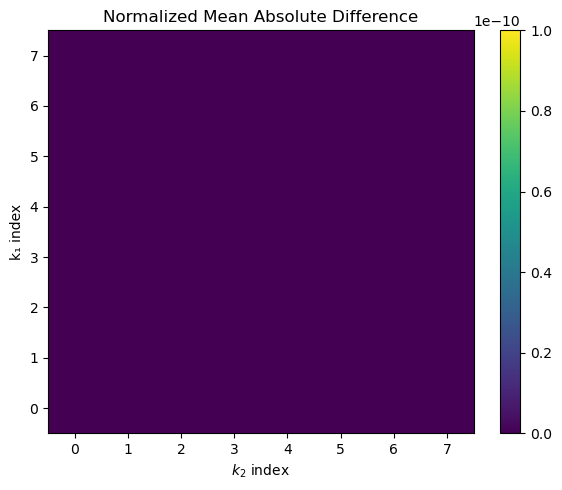

In [118]:
import matplotlib.pyplot as plt
# ——— Plot as a colour‐map ———
plt.figure(figsize=(6,5))
im = plt.imshow(
    norm_diff,
    origin='lower',        # so (0,0) is bottom‐left
    aspect='auto',         # or 'equal' if k1≈k2
)
im.set_clim(0, 1e-10)  # set color limits
plt.colorbar(im)
plt.xlabel(r'$k_2$ index')
plt.ylabel('k₁ index')
plt.title('Normalized Mean Absolute Difference')
plt.tight_layout()
plt.show()


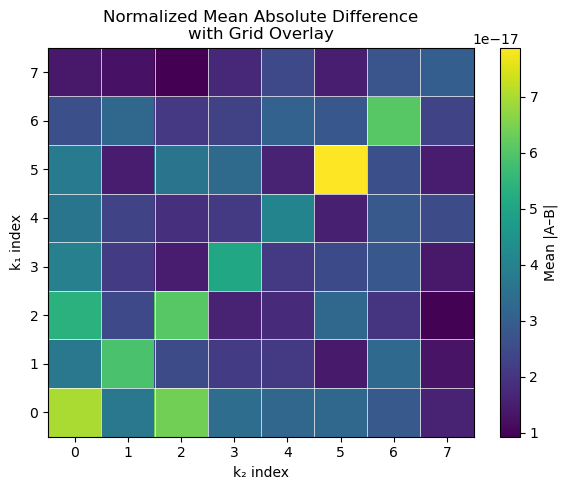

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# … after computing norm_diff of shape (k1,k2) …

k1, k2 = norm_diff.shape

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(
    norm_diff,
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# place major ticks at integer centers (optional, for labeling)
ax.set_xticks(np.arange(k2))
ax.set_yticks(np.arange(k1))
ax.set_xticklabels(np.arange(k2))
ax.set_yticklabels(np.arange(k1))

# place minor ticks at cell boundaries (half‐integers)
ax.set_xticks(np.arange(-.5, k2, 1), minor=True)
ax.set_yticks(np.arange(-.5, k1, 1), minor=True)

# turn on the grid on those minor ticks
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)

# turn off tick marks for the minor ticks (so you just see the grid lines)
ax.tick_params(which='minor', bottom=False, left=False)

plt.colorbar(im, ax=ax, label='Mean |A–B|')
plt.xlabel('k₂ index')
plt.ylabel('k₁ index')
plt.title('Normalized Mean Absolute Difference\nwith Grid Overlay')
plt.tight_layout()
plt.show()
